In [1]:
import oxonfair as fair
from oxonfair import conditional_group_metrics as cgm
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from oxonfair import dataset_loader
from matplotlib import pyplot as plt
import numpy as np

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train, val, test = dataset_loader.compas('race',train_proportion=0.75,replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train['data']['age_cat']=2*train['data']['age_cat']+train['data']['sex']


(array([2772.,    0.,    0.,    0.,    0., 1840.,    0.,    0.,    0.,
         798.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

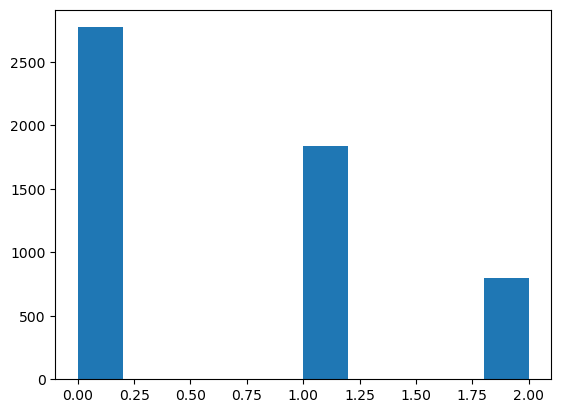

In [3]:
plt.hist(train['data']['race'])

In [4]:
#pred = XGBClassifier().fit(train['data'],train['target'])
pred = LogisticRegression().fit(train['data'],train['target'])

In [5]:
fpred = fair.FairPredictor(pred,train,conditioning_factor='age_cat')
fpred2 = fair.FairPredictor(pred,train,conditioning_factor=np.ones_like(train['groups']))

In [6]:
fpred.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.671904           0.661324  0.603529  0.331271   
         African-American    0.677850           0.677279  0.690038  0.354851   
         Caucasian           0.659783           0.606250  0.450877  0.248174   
         Other               0.679198           0.606944  0.438596  0.251968   
         Maximum difference  0.019415           0.071030  0.251442  0.106676   
updated  Overall             0.671904           0.661324  0.603529  0.331271   
         African-American    0.677850           0.677279  0.690038  0.354851   
         Caucasian           0.659783           0.606250  0.450877  0.248174   
         Other               0.679198           0.606944  0.438596  0.251968   
         Maximum difference  0.019415           0.071030  0.251442  0.106676   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.662580  0.554143  0.719851          2438.0   
         African-American     0.683162  0.697055  0.728011          1426.0   
         Caucasian            0.617788  0.354972  0.683747           724.0   
         Other                0.595238  0.347222  0.706383           288.0   
         Maximum difference   0.087923  0.349832  0.044264          1138.0   
updated  Overall              0.662580  0.554143  0.719851          2438.0   
         African-American     0.683162  0.697055  0.728011          1426.0   
         Caucasian            0.617788  0.354972  0.683747           724.0   
         Other                0.595238  0.347222  0.706383           288.0   
         Maximum difference   0.087923  0.349832  0.044264          1138.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     2972.0             0.450647   
         African-American            1346.0             0.514430   
         Caucasian                   1116.0             0.393478   
         Other                        510.0             0.360902   
         Maximum difference           836.0             0.153528   
updated  Overall                     2972.0             0.450647   
         African-American            1346.0             0.514430   
         Caucasian                   1116.0             0.393478   
         Other                        510.0             0.360902   
         Maximum difference           836.0             0.153528   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.376895  
         African-American                    0.524892  
         Caucasian                           0.226087  
         Other                               0.210526  
         Maximum difference                  0.314365  
updated  Overall                             0.376895  
         African-American                    0.524892  
         Caucasian                           0.226087  
         Other                               0.210526  
         Maximum difference                  0.314365

In [7]:
fpred.evaluate_groups(metrics=cgm.cond_measures)

Conditional Accuracy  \
         Groups                                     
original Overall                         0.669729   
         African-American                0.681977   
         Caucasian                       0.646749   
         Other                           0.680172   
         Maximum difference              0.035228   
updated  Overall                         0.669729   
         African-American                0.681977   
         Caucasian                       0.646749   
         Other                           0.680172   
         Maximum difference              0.035228   

                             Conditional True Positive Rate  \
         Groups                                               
original Overall                                   0.545366   
         African-American                          0.711035   
         Caucasian                                 0.302431   
         Other                                     0.365690   
         Maximum difference                        0.408605   
updated  Overall                                   0.545366   
         African-American                          0.711035   
         Caucasian                                 0.302431   
         Other                                     0.365690   
         Maximum difference                        0.408605   

                             Conditional True Negative Rate  \
         Groups                                               
original Overall                                   0.770097   
         African-American                          0.637478   
         Caucasian                                 0.883828   
         Other                                     0.868875   
         Maximum difference                        0.246350   
updated  Overall                                   0.770097   
         African-American                          0.637478   
         Caucasian                                 0.883828   
         Other                                     0.868875   
         Maximum difference                        0.246350   

                             Conditional False Positive Rate  \
         Groups                                                
original Overall                                    0.229903   
         African-American                           0.362522   
         Caucasian                                  0.116172   
         Other                                      0.131125   
         Maximum difference                         0.246350   
updated  Overall                                    0.229903   
         African-American                           0.362522   
         Caucasian                                  0.116172   
         Other                                      0.131125   
         Maximum difference                         0.246350   

                             Conditional False Negative Rate  \
         Groups                                                
original Overall                                    0.439982   
         African-American                           0.290024   
         Caucasian                                  0.676992   
         Other                                      0.656982   
         Maximum difference                         0.386969   
updated  Overall                                    0.439982   
         African-American                           0.290024   
         Caucasian                                  0.676992   
         Other                                      0.656982   
         Maximum difference                         0.386969   

                             Conditional Positive Prediction Rate  \
         Groups                                                     
original Overall                                         0.376262   
         African-American                                0.495254   
         Caucasian                                       0.26982

(array([ 630.,    0., 2453.,    0.,  236.,    0.,  974.,    0.,  213.,
         904.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

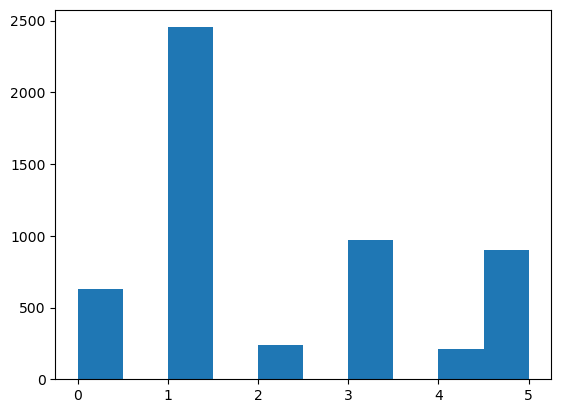

In [8]:
plt.hist(train['data']['age_cat'])

(array([[0.22510823, 0.        , 0.96392496, 0.        , 0.04761905,
         0.        , 0.27200577, 0.        , 0.0988456 , 0.39249639],
        [0.2576087 , 0.        , 0.81086957, 0.        , 0.14565217,
         0.        , 0.4826087 , 0.        , 0.05869565, 0.24456522],
        [0.20300752, 0.        , 0.92982456, 0.        , 0.09022556,
         0.        , 0.38345865, 0.        , 0.05513784, 0.33834586]]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 3 BarContainer objects>)

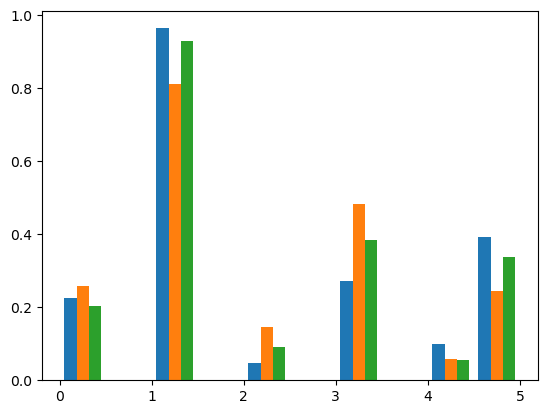

In [9]:
plt.hist([train['data']['age_cat'][train['data']['race']==0],
train['data']['age_cat'][train['data']['race']==1],
train['data']['age_cat'][train['data']['race']==2]],histtype='bar',density=True)

In [10]:
raw =dataset_loader.compas_raw()

In [11]:
raw[0]

,sex,race,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,two_year_recid
0,Male,Other,69,0,0,0,0,Greater than 45,F,0
1,Male,African-American,34,0,0,0,0,25 - 45,F,1
2,Male,African-American,24,0,0,1,4,Less than 25,F,1
3,Male,African-American,23,0,1,0,1,Less than 25,F,0
4,Male,Other,43,0,0,0,2,25 - 45,F,0
...,...,...,...,...,...,...,...,...,...,...
7209,Male,African-American,23,0,0,0,0,Less than 25,F,0
7210,Male,African-American,23,0,0,0,0,Less than 25,F,0
7211,Male,Other,57,0,0,0,0,Greater than 45,F,0
7212,Female,African-American,33,0,0,0,3,25 - 45,M,0


In [12]:
import pandas as pd
all_data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')


In [13]:
all_data['decile_score.1'].unique()

array([ 1,  3,  4,  8,  6, 10,  5,  9,  2,  7])

In [14]:
all_data.iloc[0]

id                                                    1
name                                   miguel hernandez
first                                            miguel
last                                          hernandez
compas_screening_date                        2013-08-14
sex                                                Male
dob                                          1947-04-18
age                                                  69
age_cat                                 Greater than 45
race                                              Other
juv_fel_count                                         0
decile_score                                          1
juv_misd_count                                        0
juv_other_count                                       0
priors_count                                          0
days_b_screening_arrest                            -1.0
c_jail_in                           2013-08-13 06:03:42
c_jail_out                          2013-08-14 0